### Load Factor Prediction Model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [2]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')
dataset['wgust'].replace('', np.nan, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



(1230,)
(1230, 9)


#### Approaches

##### Linear Regression

In [3]:
from sklearn.metrics  import f1_score,accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

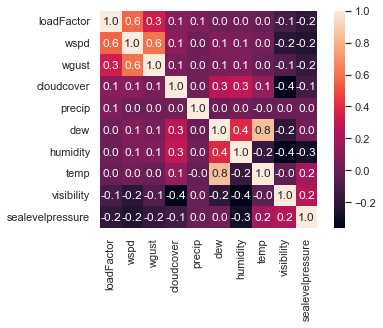

In [4]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression',LinearRegression()),
    ('Lasso',LassoCV()),
    ('ElasticNet',ElasticNet()),
    ('SGDRegressor',SGDRegressor())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', scaler),('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor',DecisionTreeRegressor()),
    ('KNN Regressor',KNeighborsRegressor()),
    ('GradBoost Regressor',GradientBoostingRegressor()),
    ('ADABoost Regressor',AdaBoostRegressor()),
    ('MLP Regressor',MLPRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', scaler),('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

Linear Models:

Linear Regression: -0.066896 (0.023027)


C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00819600715369262, tolerance: 0.008156192224775259
  model = cd_fast.enet_coordinate_descent(
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03159082122394352, tolerance: 0.0081343824521985
  model = cd_fast.enet_coordinate_descent(
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011393735944210448, tolerance: 0.008024694791460278
  model = cd_fast.enet_coordinate_descent(


Lasso: -0.067015 (0.023076)
ElasticNet: -0.097800 (0.025682)
SGDRegressor: -0.067056 (0.023047)

Non-linear Models:

DecisionTree Regressor: -0.091765 (0.026971)
KNN Regressor: -0.064099 (0.019326)
GradBoost Regressor: -0.058319 (0.023006)
ADABoost Regressor: -0.072151 (0.021159)
MLP Regressor: -0.058915 (0.021236)


Gradient Boosting Regressor Consistently the best performing model, therefore next step is to tune the hyperparameters to improve performance further